In [3]:
import os
import glob
import math
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import optimize, linalg, signal, stats

from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, RepeatedKFold, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import RFE, RFECV, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import keras
import tensorflow as tf
from keras import Model, layers, optimizers, losses, callbacks, regularizers, metrics

In [4]:
### Import Data
LN1_core = pd.read_excel(open('LN1.xlsx', 'rb'),sheet_name='core')  
LN2_core = pd.read_excel(open('LN2.xlsx', 'rb'),sheet_name='core')  
LN3_core = pd.read_excel(open('LN3.xlsx', 'rb'),sheet_name='core') 

LN1_log = pd.read_excel(open('LN1.xlsx', 'rb'),sheet_name='log')  
LN2_log = pd.read_excel(open('LN2.xlsx', 'rb'),sheet_name='log')  
LN3_log = pd.read_excel(open('LN3.xlsx', 'rb'),sheet_name='log')  

LN1_core ['WELL'] = 'LN1_core '
LN2_core ['WELL'] = 'LN2_core '
LN3_core ['WELL'] = 'LN3_core '

df_core = pd.concat([LN1_core ,LN2_core ,LN3_core])

df_core ["ln(k/phi)"] = np.log(df_core ['Kair(md)']/ df_core ['Por(%)'])
print('df_core: {}'.format(df_core.shape))
df_core.head()

df_core: (344, 23)


,Depth(m),RHOB (g/cc),DTC(rho/m),GD(g/cc),CRHOB (g/cc),GR(API),Kair(md),lnk,NPHI(v/v),PEF(b/e),...,RSHAL(ohmm),SW(v/v),SWNET(v/v),SXO(v/v),SXONET(v/v),VSHAL(v/v),WELL,Permcalc(md),PEF (b/e),ln(k/phi)
0,2993.007,2.792038,288.1894,2.649,2.212015,57.3,1950.0,7.575585,0.213187,2.675221,...,11.189480,1.000000,1.000000,1.000000,1.000000,0.951741,LN1_core,NaN,NaN,4.298440
1,2993.317,2.359790,296.7534,2.657,2.217895,82.5,947.0,6.853299,0.251199,2.522506,...,10.071730,0.581911,0.581911,0.897251,0.897251,0.352514,LN1_core,NaN,NaN,3.576154
2,2993.617,2.194946,304.3408,2.644,2.288896,93.4,977.0,6.884487,0.237218,2.513706,...,11.670710,0.335579,0.335579,0.803588,0.803588,0.146957,LN1_core,NaN,NaN,3.811793
3,2993.937,2.559232,301.3028,2.644,2.338216,77.5,149.0,5.003946,0.267802,2.574758,...,9.749550,0.948978,0.948978,0.987285,0.987285,0.697391,LN1_core,NaN,NaN,2.080785
4,2994.207,2.348028,302.3077,2.653,2.206690,91.9,2240.0,7.714231,0.251800,2.514174,...,9.494773,0.481906,0.481906,0.863907,0.863907,0.355592,LN1_core,NaN,NaN,4.418394


***
### Gradient Boosting

In [5]:
train = pd.concat([LN1_core,LN3_core])
X_train = train[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train = train['lnk'] 
print('Train - x: {} | y: {}'.format(X_train.shape, y_train.shape))

X_test = LN2_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test = LN2_core['lnk']
print('Test  - x: {} | y: {}'.format(X_test.shape, y_test.shape))

depth = LN2_core['Depth(m)']
print('Depth - {}'.format(depth.shape))

Train - x: (201, 4) | y: (201,)
Test  - x: (143, 4) | y: (143,)
Depth - (143,)


In [6]:
# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=50, random_state=42)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred  = xgb_model.predict(X_test)
print('Pred: train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))
print('MSE:  train: {:.3f}  | test: {:.3f}'.format(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R2:   train: {:.3f}  | test: {:.3f}'.format(r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Pred: train: (201,) | test: (143,)
MSE:  train: 0.003  | test: 6.301
R2:   train: 1.000  | test: 0.618


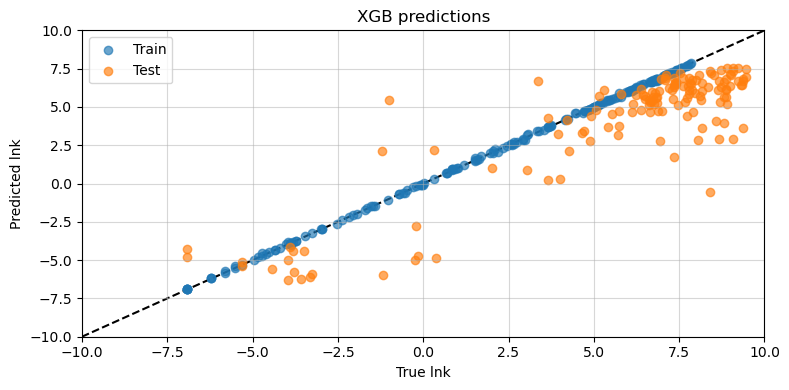

In [34]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred, marker='o', alpha=0.66, color='C1', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('XGB predictions')
plt.xlabel('True lnk'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### ANN

In [35]:
def make_model(n_layers:int=3, units:int=100, alpha:float=0.01, nonlinearity:str='relu'):

    def linear_bn_relu(x, units, nl=nonlinearity, a=alpha):
        x = layers.Dense(units, kernel_regularizer=regularizers.l2(a))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(nl)(x)
        return x

    inp = layers.Input(shape=(X_train.shape[1],))
    x = inp
    for _ in range(n_layers):
        x = linear_bn_relu(x, units)
    out = layers.Dense(1)(x)

    return Model(inputs=inp, outputs=out)

In [89]:
data_train = pd.concat([LN1_core, LN3_core])[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]
data_test  = LN2_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]

mu, sd = data_train.mean(), data_train.std()
data_train_norm = (data_train - mu) / sd
data_test_norm  = (data_test - mu) / sd

X_train_norm = data_train_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train_norm = data_train_norm['lnk']
print('X_train_norm: {} | y_train_norm: {}'.format(X_train_norm.shape, y_train_norm.shape))

X_test_norm = data_test_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test_norm = data_test_norm['lnk']
print('X_test_norm:  {} | y_test_norm:  {}'.format(X_test_norm.shape, y_test_norm.shape))

X_train_norm: (201, 4) | y_train_norm: (201,)
X_test_norm:  (143, 4) | y_test_norm:  (143,)


In [90]:
model = make_model(n_layers=3, units=128, nonlinearity='relu')
print('# parameters: {:,}'.format(model.count_params()))

model.compile(optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-2), 
              loss      = losses.MeanSquaredError(), 
              metrics   = [metrics.MeanSquaredError()])

start = time()
fit = model.fit(X_train_norm, y_train_norm, 
                epochs           = 500, 
                batch_size       = 10, 
                validation_split = 0.25,
                shuffle          = True,
                verbose          = 0)
print('Training time: {:.3f} seconds'.format(time()-start))
fit = pd.DataFrame(fit.history)

y_train_pred_nn = model.predict(X_train_norm, verbose=False) * sd['lnk'] + mu['lnk']
y_test_pred_nn  = model.predict(X_test_norm, verbose=False) * sd['lnk'] + mu['lnk']
print('NN - train: {} | test: {}'.format(y_train_pred_nn.shape, y_test_pred_nn.shape))

print('MSE: train: {:.3f} | test: {:.3f}'.format(mean_squared_error(data_train['lnk'], y_train_pred_nn), mean_squared_error(data_test['lnk'], y_test_pred_nn)))
print('R2:  train: {:.3f} | test: {:.3f}'.format(r2_score(data_train['lnk'], y_train_pred_nn), r2_score(data_test['lnk'], y_test_pred_nn)))

# parameters: 35,329
Training time: 25.569 seconds
NN - train: (201, 1) | test: (143, 1)
MSE: train: 2.856 | test: 4.149
R2:  train: 0.850 | test: 0.748


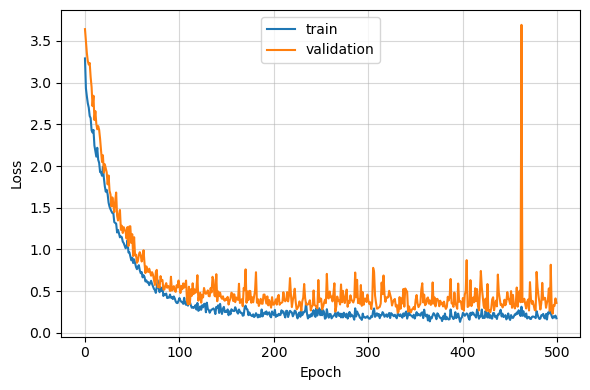

In [91]:
plt.figure(figsize=(6,4))
plt.plot(fit['loss'], label='train')
plt.plot(fit['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

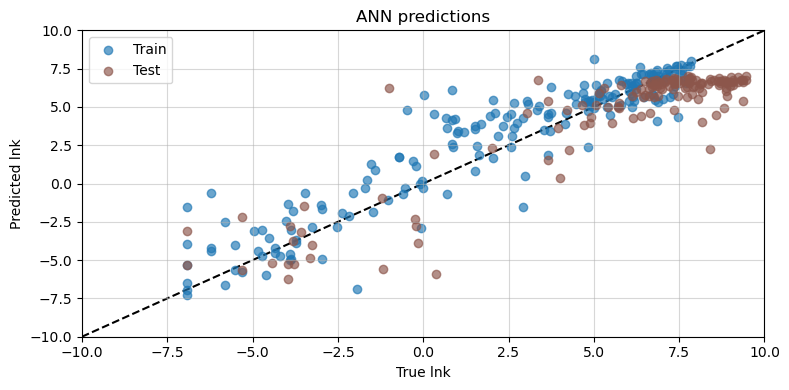

In [106]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred_nn, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred_nn, marker='o', alpha=0.66, color='tab:brown', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('ANN predictions')
plt.xlabel('True lnk'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### Ensemble

In [94]:
# Now, create stochastic simulations by generating random perturbations in the input features
mu_test, sd_test = X_test.mean(), X_test.std()

n_simulations = 10

random_inputs = np.zeros((n_simulations, depth.shape[0], X_test.shape[1]))
random_inputs_norm = np.zeros((n_simulations, depth.shape[0], X_test.shape[1]))

simulated_lnk_xgb = np.zeros((n_simulations, depth.shape[0]))
simulated_lnk_ann = np.zeros((n_simulations, depth.shape[0]))

start = time()
for i in range(n_simulations):
    for k in range(X_test.shape[-1]):
        random_inputs[i, :, k] = X_test.iloc[:,k] + np.random.normal(0, sd_test[k], size=depth.shape[0])
        random_inputs_norm[i, :, k] = (random_inputs[i, :, k] - mu_test[k]) / sd_test[k]
    simulated_lnk_xgb[i] = xgb_model.predict(random_inputs[i])
    simulated_lnk_ann[i] = model.predict(random_inputs_norm[i], verbose=False).squeeze() * sd['lnk'] + mu['lnk']
print('Simulation time: {:.3f} seconds'.format(time()-start))

print('Random inputs ensemble: {}'.format(random_inputs.shape))
print('Simulated lnK ensemble XGB: {}'.format(simulated_lnk_xgb.shape))
print('Simulated lnK ensemble ANN: {}'.format(simulated_lnk_ann.shape))

Simulation time: 0.681 seconds
Random inputs ensemble: (10, 143, 4)
Simulated lnK ensemble XGB: (10, 143)
Simulated lnK ensemble ANN: (10, 143)


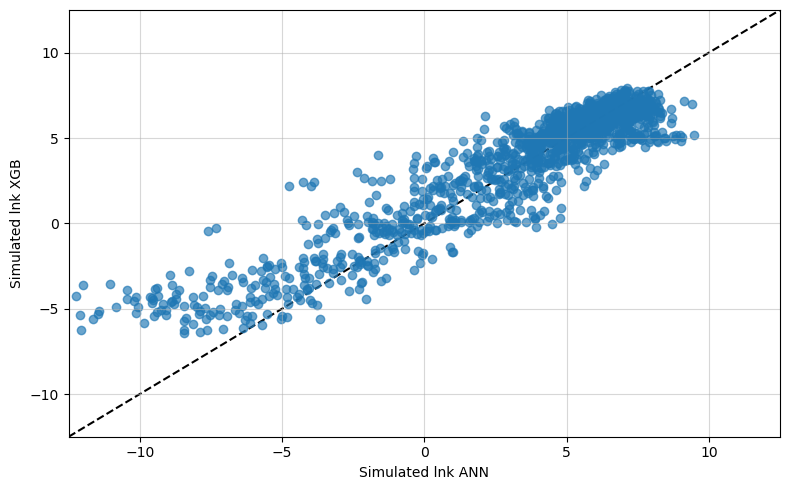

In [96]:
plt.figure(figsize=(8,5))
lims = 12.5
for i in range(n_simulations):
    plt.scatter(simulated_lnk_ann[i], simulated_lnk_xgb[i], marker='o', alpha=0.66, color='C0')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-lims, lims); plt.ylim(-lims, lims)
plt.xlabel('Simulated lnk ANN'); plt.ylabel('Simulated lnk XGB')
plt.tight_layout()
plt.show()

***
### XGB Predictions

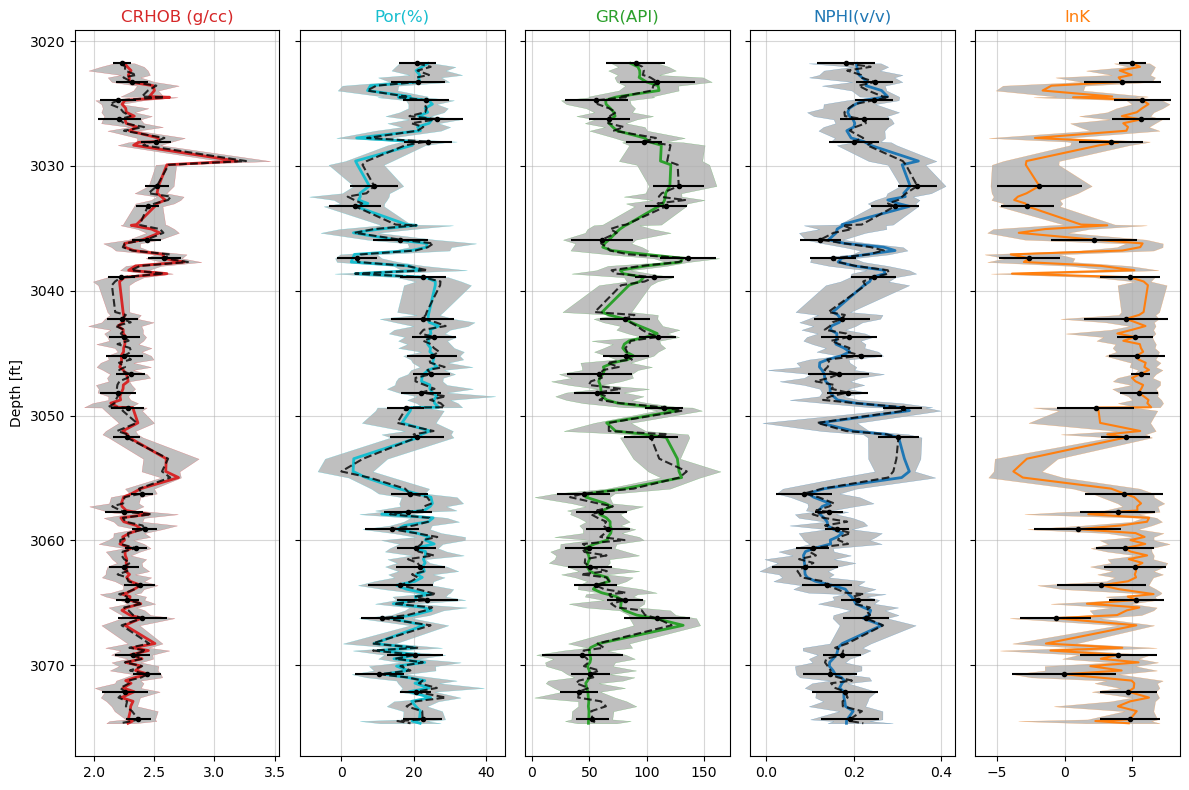

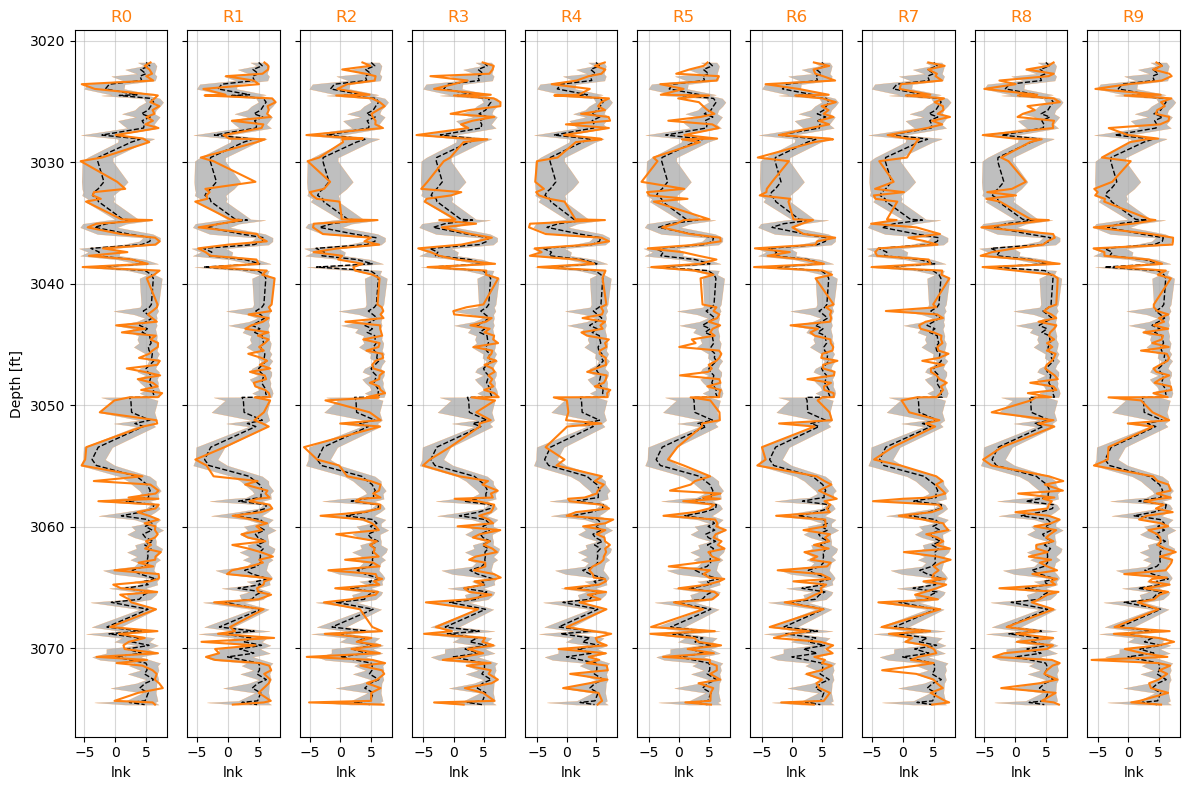

In [99]:
hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:orange']
err_lag = 5
lb, ub = 10, 90

fig, axs = plt.subplots(1, 5, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-1].plot(simulated_lnk_xgb.mean(0), depth, color=hues[-1])
axs[-1].fill_betweenx(depth, np.percentile(simulated_lnk_xgb, lb, axis=0), np.percentile(simulated_lnk_xgb, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-1].errorbar(simulated_lnk_xgb[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_xgb[:,::err_lag].std(0), fmt='.', color='k')
axs[-1].set_title('lnK', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(12,8), sharey=True)
for j in range(10):
    ax = axs[j]
    ax.plot(simulated_lnk_xgb.mean(0), depth, color='k', ls='--', lw=1) # Ensemble mean
    ax.plot(simulated_lnk_xgb[j], depth, color=hues[-1])                # Individual simulation/realization
    ax.fill_betweenx(depth, np.percentile(simulated_lnk_xgb, lb, axis=0), np.percentile(simulated_lnk_xgb, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
    ax.set_title('R{}'.format(j), color=hues[-1])
ax.invert_yaxis()
[a.grid(True, which='both', alpha=0.5) for a in axs]
[a.set(xlabel='lnk') for a in axs]
axs[0].set_ylabel('Depth [ft]')
plt.tight_layout()
plt.show()

***
### ANN Predictions

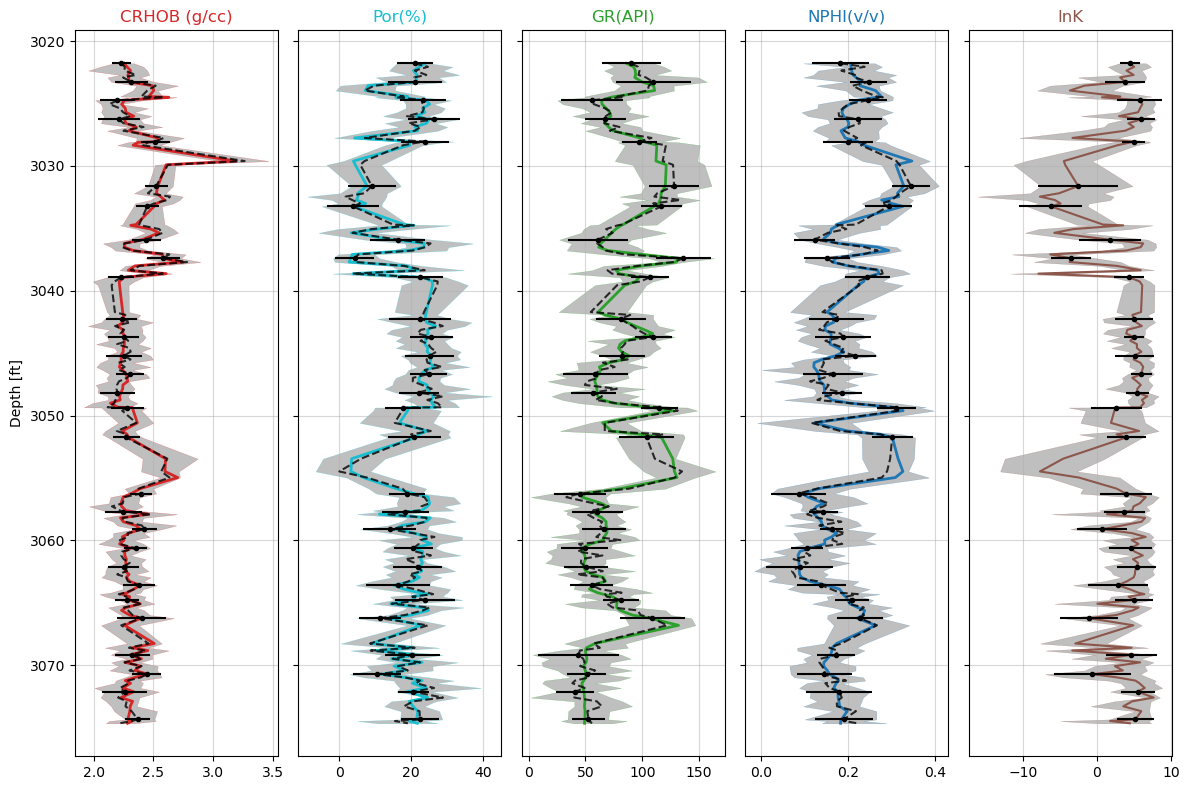

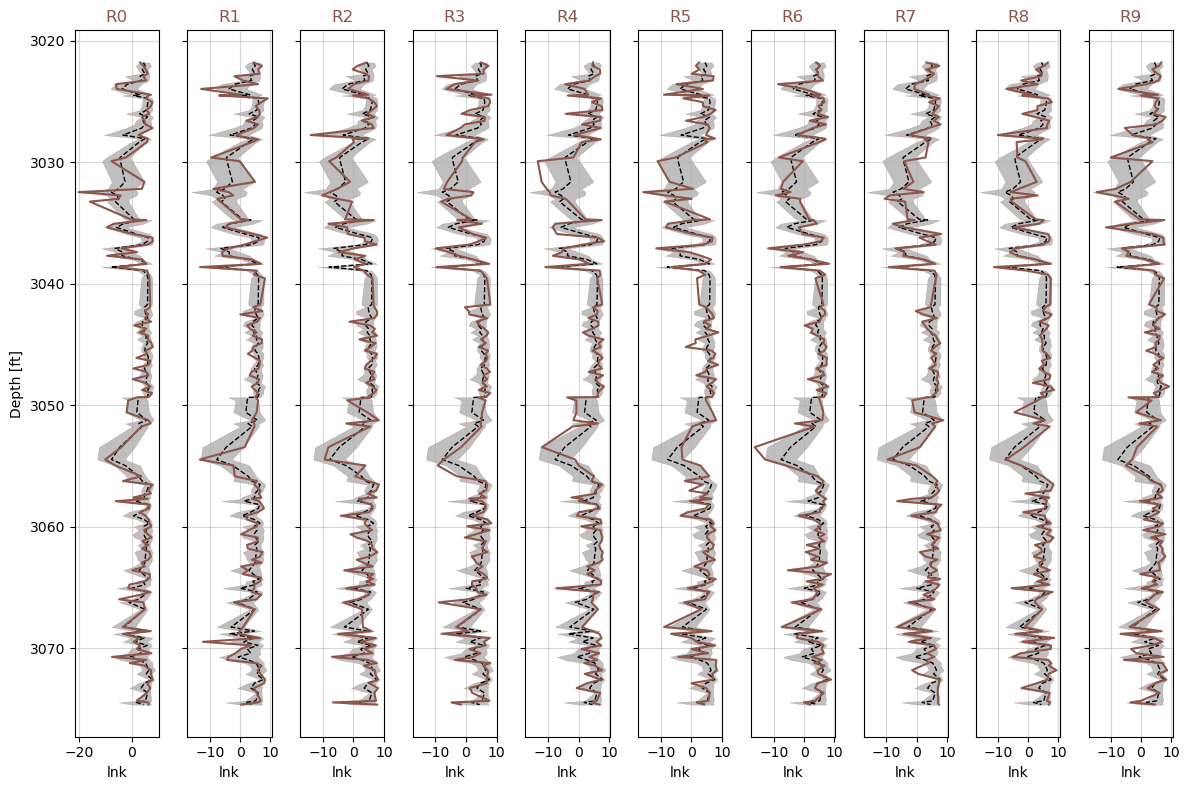

In [105]:
hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:brown']
err_lag = 5
lb, ub = 10, 90

fig, axs = plt.subplots(1, 5, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-1].plot(simulated_lnk_ann.mean(0), depth, color=hues[-1])
axs[-1].fill_betweenx(depth, np.percentile(simulated_lnk_ann, lb, axis=0), np.percentile(simulated_lnk_ann, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-1].errorbar(simulated_lnk_ann[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_ann[:,::err_lag].std(0), fmt='.', color='k')
axs[-1].set_title('lnK', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(12,8), sharey=True)
for j in range(10):
    ax = axs[j]
    ax.plot(simulated_lnk_ann.mean(0), depth, color='k', ls='--', lw=1) # Ensemble mean
    ax.plot(simulated_lnk_ann[j], depth, color=hues[-1])                # Individual simulation/realization
    ax.fill_betweenx(depth, np.percentile(simulated_lnk_ann, lb, axis=0), np.percentile(simulated_lnk_ann, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
    ax.set_title('R{}'.format(j), color=hues[-1])
ax.invert_yaxis()
[a.grid(True, which='both', alpha=0.5) for a in axs]
[a.set(xlabel='lnk') for a in axs]
axs[0].set_ylabel('Depth [ft]')
plt.tight_layout()
plt.show()

***
# END